In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
import warnings

warnings.filterwarnings(action="ignore", category=pd.errors.PerformanceWarning)

In [16]:
# file_path = '/Users/johannes/Dropbox/ML AP Project/empirical analysis/data/gfin_data_yly_and_mthly_global_fin_p1.RData'
file_path = "/Users/johannes/Dropbox/ML AP Project/empirical analysis/data/pdata_mthly_fin.RData"
df = pyreadr.read_r(file_path)

In [ ]:
# df = df['cstatmerged_p1']
df = df["panel_mthly"]

In [19]:
cols = df.columns.to_frame()

In [18]:
# Convert data in required format

date_columns = ["date", "datadate_yly", "beg4mgap", "end4mgap"]
df[date_columns] = df[date_columns].apply(pd.to_datetime, errors="coerce")

# convert int columns defined as object to int
df["age"] = df["age"].astype("Int64")
df["exchg"] = df["exchg"].astype("Int64")

cols_with_dtype = df.dtypes.to_frame()

KeyError: "None of [Index(['date', 'datadate_yly', 'beg4mgap', 'end4mgap'], dtype='object')] are in the [columns]"

In [20]:
gvkeys_list = df["gvkey"].unique()

gvkey_test = df[df["gvkey"] == gvkeys_list[7114]]

In [21]:
# Check if columns country.x and country.y are equal
df["country.x"] = df["country.x"].str.lower()
# df["country.y"] = df["country.y"].str.lower()

# generate a dataframe which is called equal_country which contains country.x and country.y from df
equal_country = df[["gvkey", "country.x", "country.y"]].copy()

equal_country["country_x_stable"] = (
    equal_country.groupby("gvkey")["country.x"].transform("nunique") == 1
)
equal_country["country_y_stable"] = (
    equal_country.groupby("gvkey")["country.y"].transform("nunique") == 1
)

equal_country["country_equal"] = (
    equal_country["country.x"] == equal_country["country.y"]
)

equal_country = equal_country.drop_duplicates(subset="gvkey", keep="first")


# Function to plot the occurrence of countries with options to normalize, limit to top N countries, and count NaN values
def plot_country_occurrence(
    df: pd.DataFrame,
    normalize: bool = False,
    top_n: int = None,
    count_nan: bool = False,
):
    # Count the occurrences of each country
    country_counts = df["country.x"].value_counts().reset_index()
    country_counts.columns = ["country", "count"]

    if normalize:
        # Normalize the values by dividing by the total number of countries
        total_counts = country_counts["count"].sum()
        country_counts["count"] = country_counts["count"] / total_counts

    if top_n:
        # Limit to the top N countries
        country_counts = country_counts.head(top_n)

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(country_counts["country"], country_counts["count"])
    plt.xticks(rotation=90)
    plt.xlabel("Country")
    plt.ylabel("Count" if not normalize else "Proportion")
    plt.title(
        "Occurrence of Countries" + (" (Normalized)" if normalize else "")
    )
    plt.show()

    if count_nan:
        if normalize:
            # Count the number of NaN values in the 'country.x' column
            nan_count = df["country.x"].isna().sum() / len(df)
            print(f"Proportion of NaN values in country.x: {nan_count}")
        else:
            nan_count = df["country.x"].isna().sum()
            print(f"Number of NaN values in country.x: {nan_count}")


# Example usage
plot_country_occurrence(
    equal_country, normalize=True, top_n=10, count_nan=True
)  # Without normalization
# plot_country_occurrence(equal_country, normalize=True)

KeyError: 'country.x'

In [ ]:
# count unique gfkeys and the number of observations for each gfkey
unique_gfkeys = df[["gvkey", "country.x"]].copy()
unique_gfkeys["obs_count"] = df["gvkey"].value_counts().to_frame()


# Function to plot the distribution of the number of gvkeys with a given number of observations
def plot_obs_distribution(
    df: pd.DataFrame, country: str = None, normalize: bool = False
):
    if country:
        # Filter the DataFrame for the specified country
        country_df = df[df["country.x"] == country]
    else:
        # Use the entire DataFrame if no country is specified
        country_df = df

    # Count the number of observations per gvkey
    obs_count = country_df.groupby("gvkey").size().reset_index(name="obs_count")

    # Count how many gvkeys have each number of observations
    obs_distribution = obs_count["obs_count"].value_counts().reset_index()
    obs_distribution.columns = ["num_observations", "num_gvkeys"]

    # Sort the values for better visualization
    obs_distribution = obs_distribution.sort_values(by="num_observations")

    if normalize:
        # Normalize the values by dividing by the total number of gvkeys
        total_gvkeys = obs_distribution["num_gvkeys"].sum()
        obs_distribution["num_gvkeys"] = (
            obs_distribution["num_gvkeys"] / total_gvkeys
        )

    # Plot the bar chart
    plt.figure(figsize=(20, 10))
    plt.bar(
        obs_distribution["num_observations"], obs_distribution["num_gvkeys"]
    )
    plt.xlabel("Number of Observations")
    plt.ylabel("Number of gvkeys" if not normalize else "Proportion of gvkeys")
    if country:
        plt.title(
            f"Distribution of Number of Observations per gvkey for {country}"
        )
    else:
        plt.title(
            "Distribution of Number of Observations per gvkey for All Countries"
        )
    plt.show()


plot_obs_distribution(unique_gfkeys, country=None, normalize=True)

In [ ]:
# for each gvkey check if there is only a unique value in the column country.x, if so add the entry to the column country in unique_gfkeys if not say not defined


def country_inspection(df: pd.DataFrame = df, col: str = None):
    unique_gfkeys[col] = None
    for i in unique_gfkeys.index:
        if len(df[df["gvkey"] == i][col].unique()) == 1:
            unique_gfkeys.loc[i, col] = df[df["gvkey"] == i][col].unique()[0]
        else:
            unique_gfkeys.loc[i, col] = "not unique"


country_inspection(df, "country.x")

In [22]:
# for each numeric column and each gvkey in df calculate the min, max, mean, and standard deviation and store these values in a new dataframe where the columns have the respective names with a suffix
# that indicates the respective statistic


def calculate_statistics(df: pd.DataFrame = df, cols: list = None):
    statistics = pd.DataFrame()
    for col in cols:
        statistics[col + "_min"] = df.groupby("gvkey")[col].min()
        statistics[col + "_max"] = df.groupby("gvkey")[col].max()
        statistics[col + "_mean"] = df.groupby("gvkey")[col].mean()
        statistics[col + "_std"] = df.groupby("gvkey")[col].std()

    return statistics


numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop("gvkey")

statistics = calculate_statistics(df, numeric_cols)

# drop rows which only contain NaN values
statistics = statistics.dropna(how="all")

In [23]:
# Calculate the missing values for each gvkey and each column and normalize the result over all observations for each gvkey


def calculate_missing_values(df: pd.DataFrame = df):
    missing_values = pd.DataFrame()
    for col in df.columns:
        missing_values[col + "_missing"] = df.groupby("gvkey")[col].apply(
            lambda x: x.isnull().sum() / len(x)
        )

    return missing_values


missing_values = calculate_missing_values(df)

# join the object columns from df with missing_values. merge on gvkey
object_cols = df.select_dtypes(include=[object]).columns
object_cols = object_cols.append(pd.Index(["gvkey"]))
object_df = df[object_cols].drop_duplicates(subset="gvkey", keep="first")

object_df = object_df.set_index("gvkey")

# join the object columns from df with missing_values. merge on gvkey
missing_values = object_df.join(missing_values, on="gvkey")

descriptive_stats_missing_values = missing_values.describe()

In [24]:
# write a function that takes a respective input dataframe and returns two new dataframes.
# the first dataframe should compute
# the mean, median, min, max, standard deviation 25th and 75th percentile of the respective column.
# the second dataframe
# should compute the average of all rows (for each gvkey) calculate the number of missing values in each column as
# percentage of the length of the timeseries and store the result in a new dataframe


def calculate_descriptive_statistics(df: pd.DataFrame):
    descriptive_statistics = pd.DataFrame(
        index=[
            "mean",
            "median",
            "min",
            "max",
            "std",
            "25th_percentile",
            "75th_percentile",
        ]
    )
    for col in df.columns:
        if df[col].dtype == "float64" or df[col].dtype == "int64":
            descriptive_statistics[col] = [
                df[col].mean(),
                df[col].median(),
                df[col].min(),
                df[col].max(),
                df[col].std(),
                df[col].quantile(0.25),
                df[col].quantile(0.75),
            ]

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df = df[numeric_cols]

    index = df.index
    row_statistics = pd.DataFrame(index=index)
    row_statistics["mean"] = df.mean(axis=1)
    row_statistics["std"] = df.std(axis=1)
    row_statistics["min"] = df.min(axis=1)
    row_statistics["25th_percentile"] = df.quantile(0.25, axis=1)
    row_statistics["median"] = df.median(axis=1)
    row_statistics["75th_percentile"] = df.quantile(0.75, axis=1)
    row_statistics["max"] = df.max(axis=1)

    return descriptive_statistics, row_statistics


descriptive_statistics, row_statistics = calculate_descriptive_statistics(
    missing_values
)

<Axes: >

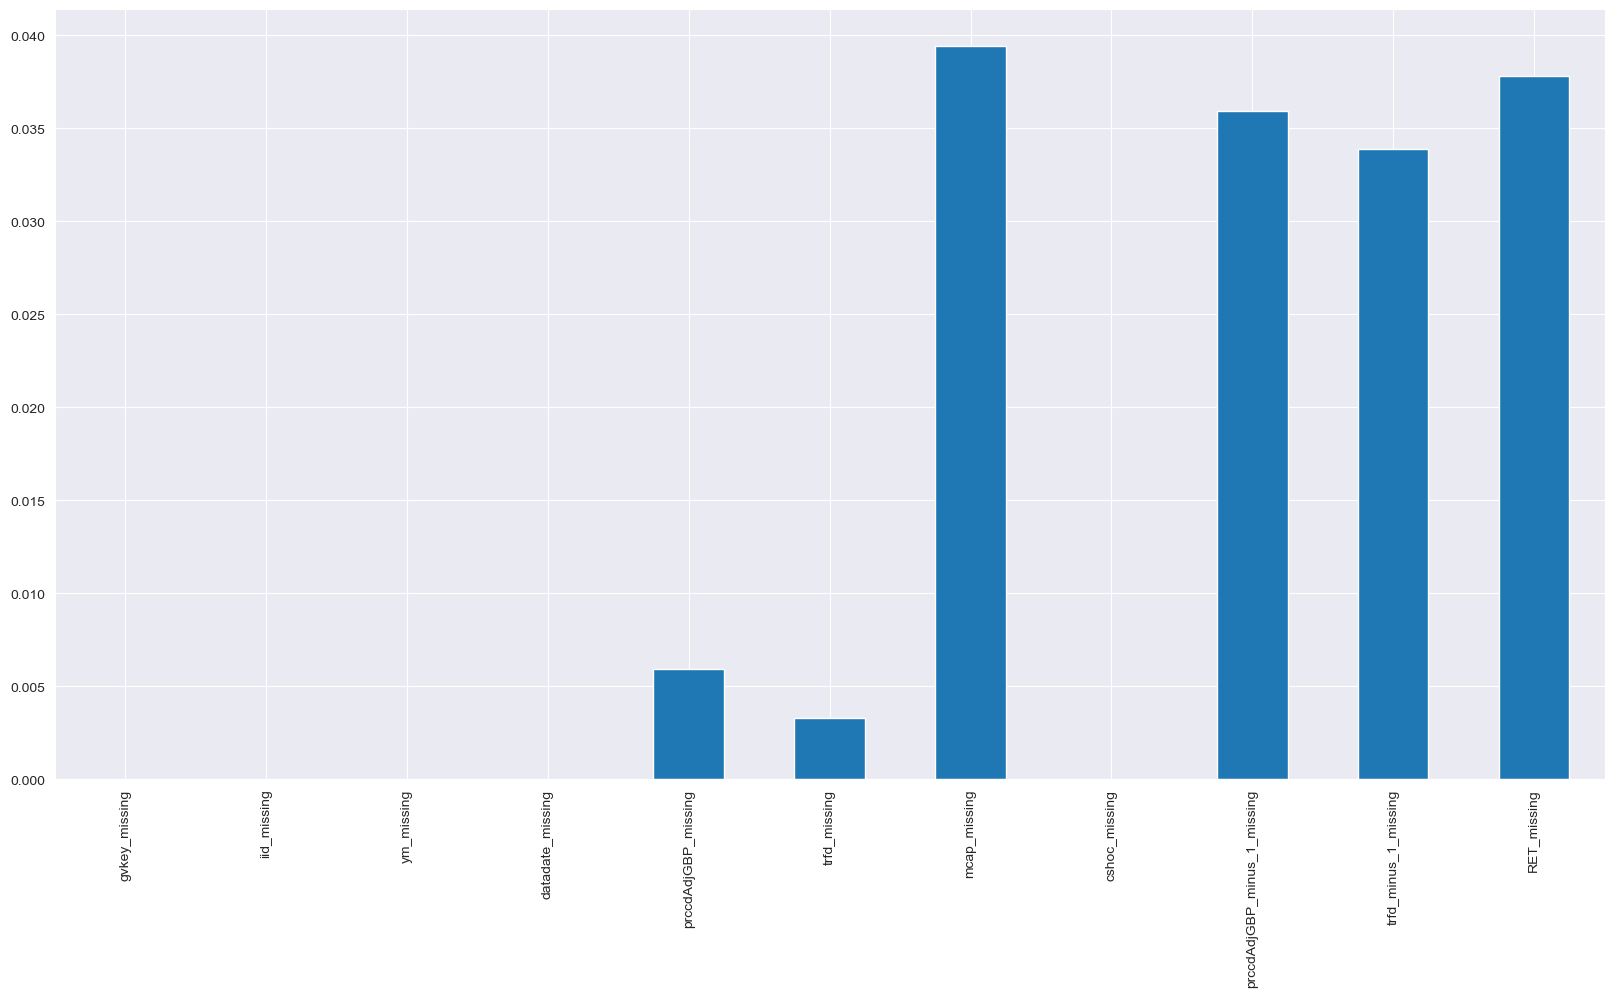

In [25]:
# generate a bar plot which plots the mean of each column in descriptive_statistics

descriptive_statistics = descriptive_statistics.T
plt.figure(figsize=(20, 10))
descriptive_statistics["mean"].plot(kind="bar")
# plt.show()

In [26]:
# count the number of -inf and inf values in each column of df and store the result in a new dataframe
def count_inf_values(df: pd.DataFrame):
    inf_values = pd.DataFrame(index=["count"])
    for col in df.columns:
        if df[col].dtype == "float64" or df[col].dtype == "int64":
            inf_values[col + "_inf"] = [
                df[col].apply(lambda x: np.isinf(x)).sum()
            ]
    return inf_values


# Calculate infinity values
inf_values = count_inf_values(df)

In [27]:
# check if there are rows in df which contain a value in prccdAdjGBP bur not in RET. if so, store gvkey in a list

gvkeys_list = df["gvkey"].unique()
gvkey_list = []
for gvkey in gvkeys_list:
    if df[df["gvkey"] == gvkey]["prccdAdjGBP"].notna().all():
        if df[df["gvkey"] == gvkey]["RET"].isna().all():
            gvkey_list.append(gvkey)